# TF-IDF para RI

El método de TF-IDF (term frequency-inverse document frequency) tiene amplias aplicaciones en la recuperación de información. Aquí revisamos dos de esas aplicaciones:

* Para determinar las palabras claves dentro de un documento.
* Para realizar recuperación de documentos en base a un score.

In [1]:
from nltk.corpus import brown
from nltk.stem import SnowballStemmer
from collections import defaultdict, Counter
from itertools import chain
from wordcloud import WordCloud
from operator import itemgetter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Obtención de la colección

Para crear el corpus tomamos documentos de diferentes tópicos del corpus inglés Brown. Definimos una función para tratar los tokens, de tal forma que esta función la podamos aplicar también a las queries.

In [2]:
#Algoritmo de stemming
stemmer = SnowballStemmer('english')

#Función para tratar al token
tokenize = lambda token: stemmer.stem(token.lower())    

Creamos la lsita de documentos y la lista de términos y de sus frecuencias

In [3]:
#Recupera ids de ciertos tópicos en el corpus
doc_ids = brown.fileids(categories=['romance'])[:5] + brown.fileids(categories=['religion'])[:5] + brown.fileids(categories=['government'])[:5] #brown.categories())

#Guarda los documentos
documents = defaultdict(list)
for docID in doc_ids:
    #Recupera los tokens
    tokens = brown.words(docID)
    for w in tokens:
        #Guarda los tokens alfanuméricos
        if w.isalpha() != False:
            documents[docID].append(tokenize(w))

#Guarda los terminos
terms = list(chain(*[tokens for tokens in documents.values()]))
#Frecuencia de terminos
term_frequencies = Counter(terms)
#Total de documentos considerados
num_documents = len(documents)

#### Frecuencias

Observamos que las frecuencias no son buenos candidatos, existen hapax que no son palabras claves; asimismo, las palabras de alta frecuencia no son para nada palabras claves.

In [4]:
term_list = pd.DataFrame(sorted(term_frequencies.items(), key=itemgetter(1), reverse=True), 
                         columns=['Token','Frequency'])

term_list = term_list.set_index(term_list['Token'])
term_list.pop('Token')
term_list

,Frequency
Token,
the,1920
of,1179
and,969
to,865
in,658
...,...
unknown,1
aggreg,1
guard,1


### Inverse document frequency

La frecuencia inversa en documentos o <b>IDF</b> determina la distribución de los términos a través de los documentos del corpus. El IDF será más alto cuando el término aparezca en pocos documentos, y tenderá a 0 cuando aparezca en más documentos. Calculamos el IDF de un término como:

$$idf(w) = -\log \frac{|\{d : w \in d\}|}{|D|}$$

In [5]:
#Guarda los idf para cada términos
idf = {}
for term in term_list.index:
    #Total de documentos en que
    #aparece el término
    total_documents = 0
    for doc, token_list in documents.items():
        if term in token_list:
            total_documents += 1
            
    #Asignación de idf
    idf[term] = -np.log2(total_documents/num_documents)

In [6]:
#Agregamos el idf al dataframe
term_list['idf'] = idf.values()
term_list.sort_values(by='idf', ascending=False)

,Frequency,idf
Token,,
brethren,2,3.906891
oppress,1,3.906891
wand,1,3.906891
everlast,1,3.906891
fete,1,3.906891
...,...,...
at,144,-0.000000
or,147,-0.000000
which,148,-0.000000


### TF-IDF

Para calcular el TFIDF de un término usamos la frecuencia de término dentro de un documento o TF que se calcula como:

$$ tf_{i,j} = \alpha + (1-\alpha) \frac{f_{i,j}}{\max \{f_{k,j} : w_k \in d_j \}}$$
    
tal que $\alpha\in [0,1]$.

Finalmente, el TFIDF se calcula como:

$$tfidf_{i,j} = tf_{i,j} \cdot idf_i$$

In [7]:
#Parametro
a = 0.5

#Guarda los tfidf
tfidf = {}
for doc, token_list in documents.items():
    #Cuenta la frecuencia del término en el documento
    term_freq_doc = Counter(token_list)
    #Obtiene la frecuencia mayor
    max_freq = np.max(list(term_freq_doc.values()))
    #Guarda tfidf por documento
    tfidf_doc = {}
    for term in term_freq_doc:
        #Valor de TF
        tf = a + (1-a)*(term_frequencies[term]/max_freq)
        #Valor de tfidf
        tfidf_doc[term] = tf*idf[term]
        
    tfidf[doc] = tfidf_doc

Podemos visualizar cuáles son los términos más destacadas según su TFIDF por cada tópico del corpus.

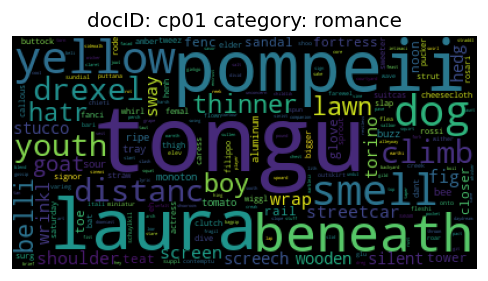

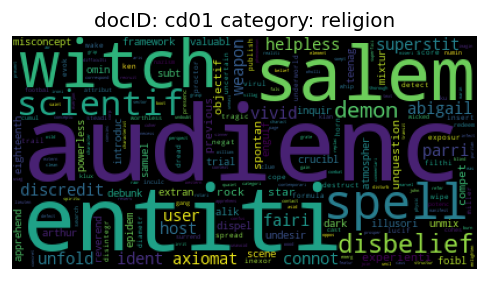

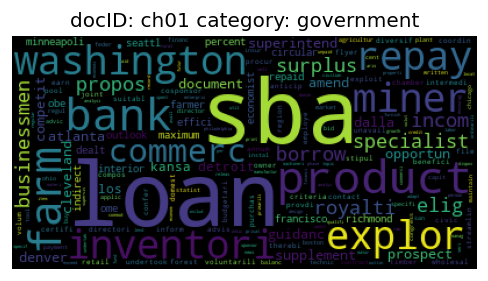

In [8]:
for docID in ['cp01', 'cd01', 'ch01']:
    #Visualizar como nube de palabras
    mycloud = WordCloud()
    mycloud.generate_from_frequencies(tfidf[docID])

    plt.figure(figsize=(5,8), dpi=120)
    plt.title('docID: {} category: {}'.format(docID, brown.categories(docID)[0]))
    plt.imshow(mycloud)
    plt.axis("off")
    plt.show()

### Recuperación de documentos con TFIDF

Podemos recuperar los documentos usando un peso basado en TFIDF. Dado una query $q$ compuesta por varios términos, el escore del documento $d_j$ dado la query se estima como:

$$score(q, d_j) = \sum_{i} tfidf_{i,j}$$

Así, el documento con mayor TFIDF para esa query será el que aparecerá primero como recomendación en la búsqueda.

In [9]:
def recover_documents(query, tfidf_weights):
    """
    Función para recuperar documentos en base a su valor de TFIDF.
    
    Arguments
    ---------
    query : str
        Consulta que se desea hacer para satisfacer la necesidad de información.
    tfidf_weights : dict
        Diccionario de tfidf por documentos y términos
    """
    #Obtener términos en query y procesarlos
    proc_query = [tokenize(w) for w in query.split()]
    for docID, tfidf_doc in tfidf_weights.items():
        #Guarda el score
        score = 0
        for w in proc_query:
            #Revisa si el término está en documento
            if w in tfidf_doc.keys():
                #Suma el score
                score += tfidf_doc[w]
            
        yield docID, score

Podemos ver qué tal funciona la búsqueda con TFIDF haciendo una consulta:

In [10]:
#Consulta
query = 'government administration'
#Resultados de la consulta
results = recover_documents(query, tfidf)
#Ordena la consulta de mayor peso a menor
sorted_results = sorted(results, key=itemgetter(1), reverse=True)

for docID, score in sorted_results:
    print('docID: {}, score: {}, category: {}'.format(docID, score, brown.categories(docID)[0]))

docID: ch01, score: 1.7129761113385755, category: government
docID: ch02, score: 1.6953224435194068, category: government
docID: ch03, score: 1.6742434371681607, category: government
docID: ch04, score: 1.6577614481594738, category: government
docID: ch05, score: 1.6448833926074964, category: government
docID: cp02, score: 0.7761428283888806, category: romance
docID: cd05, score: 0.7112381105137033, category: religion
docID: cp01, score: 0, category: romance
docID: cp03, score: 0, category: romance
docID: cp04, score: 0, category: romance
docID: cp05, score: 0, category: romance
docID: cd01, score: 0, category: religion
docID: cd02, score: 0, category: religion
docID: cd03, score: 0, category: religion
docID: cd04, score: 0, category: religion


#### Tabla de TFIDF

Los valores de TFIDF se pueden visualizar como una tabla o matriz que relaicona los documentos con los términos. Cada término tiene un valor de tfidf para un documento determinado. Esta es una forma de representar los documentos.

In [11]:
tfidf_matrix = pd.DataFrame(tfidf).fillna(0).T

tfidf_matrix #.to_numpy().shape

,they,neither,like,nor,dislik,the,old,man,to,them,...,barrington,bristol,narragansett,wester,unknown,aggreg,guard,harbor,season,hurrican
cp01,-0.0,0.693319,0.210491,0.507351,1.185320,-0.0,0.474132,0.548859,-0.0,0.214994,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cp02,-0.0,0.706324,0.230400,0.000000,0.000000,-0.0,0.516598,0.000000,-0.0,0.236712,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cp03,-0.0,0.000000,0.255396,0.000000,1.207403,-0.0,0.569920,0.712400,-0.0,0.263981,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cp04,-0.0,0.000000,0.233234,0.000000,0.000000,-0.0,0.522644,0.631685,-0.0,0.239804,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cp05,-0.0,0.000000,0.220985,0.000000,0.000000,-0.0,0.496515,0.587074,-0.0,0.226441,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cd01,-0.0,0.692016,0.208497,0.505181,0.000000,-0.0,0.000000,0.541596,-0.0,0.212818,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cd02,-0.0,0.000000,0.000000,0.504495,0.000000,-0.0,0.000000,0.539303,-0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cd03,-0.0,0.696830,0.000000,0.513202,0.000000,-0.0,0.000000,0.568435,-0.0,0.220858,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cd04,-0.0,0.000000,0.210148,0.506977,0.000000,-0.0,0.473398,0.547606,-0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cd05,-0.0,0.693319,0.210491,0.507351,1.185320,-0.0,0.474132,0.000000,-0.0,0.214994,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
